## Transformers

### GPU selection

Select the GPU id to use.

In [1]:
# Select the right device. Change the number to select a different GPU.
# If you have used slurm to request a GPU, just keep this line as it is.
device_id = 0

In [2]:
import torch
from torch import cuda
from multiprocessing import cpu_count

# Automatic device selection
if cuda.is_available():
    torch.set_num_threads(cpu_count() // cuda.device_count())
    device = torch.device(f"cuda:{device_id}")
else:
    torch.set_num_threads(cpu_count())
    device = torch.device("cpu")
device

device(type='cuda', index=0)

### Hyperparameters

These are the hyperparameters used throughout this chapter. Placed here for
easier experiments.

In [3]:
from typing import Type

from torch import nn, optim


class Params:
    def __init__(self,
                 batch_size: int = 128, epochs: int = 20, lr: float = 1e-4,
                 embedding_dim: int = 32, key_dim: int = 32,
                 hidden_dim: int = 128, n_heads: int = 4, num_layers: int = 3,
                 dropout: float = 0.2, pooling: str = "mean",
                 Optimizer: Type[optim.Optimizer] = optim.Adam,
                 print_every: int = 4):
        # Training hyperparams
        self.batch_size = batch_size
        self.epochs = epochs

        # Model hyperparams
        self.embedding_dim = embedding_dim
        self.key_dim = key_dim
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.num_layers = num_layers
        self.dropout = dropout
        self.pooling = pooling

        # Optimizer hyperparams
        self.Optimizer = Optimizer
        self.lr = lr

        # Misc
        self.print_every = print_every


SEED = 42
params = Params()

### Data preprocessing

We'll use the same dataset from the previous chapter: `hERG Central`.

In [4]:
import re
from collections import Counter
from typing import List, Tuple

import pandas as pd
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

label_list = retrieve_label_name_list("herg_central")
data = Tox(name='herg_central', label_name=label_list[2])
split = data.get_split()

token_re = re.compile(r"(\[[^\]]+\]|Cl|Br|[BCNOPSFIbcnops]|.)")
bracket_re = re.compile(r"(\d+|[A-Z][a-z]*|[a-z]+|.)")


def smi_to_tok(smiles: str):
    for tok in token_re.finditer(smiles):
        tok = tok.group()
        if tok.startswith("["):
            for t in bracket_re.finditer(tok):
                yield t.group()
        else:
            yield tok


mapping = Counter(tok for smiles in data.entity1 for tok in smi_to_tok(smiles))
tok_to_idx = {
    tok: idx for idx, (tok, _) in enumerate(mapping.most_common(), 1)}


class HergCentralDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.smiles = [
            torch.tensor([tok_to_idx[tok] for tok in smi_to_tok(smiles)])
            for smiles in data["Drug"]]
        self.y = torch.tensor(data["Y"].values, dtype=torch.long)

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        x = self.smiles[idx]
        y = self.y[idx]
        return x, y

    # It is a good idea to have collate_fn as a static method of the dataset
    # class, because it is tightly related to the dataset.
    # Q) Why a static method, instead a normal method?
    @staticmethod
    def collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor]]):
        x, y = zip(*batch)
        # Shape: N (L_i, ) sized tensors -> (N, max(L_i))
        x = pad_sequence(x, batch_first=True)
        # Shape: N * (, ) -> (N, )
        y = torch.stack(y)
        return x, y


datasets = {k: HergCentralDataset(v) for k, v in split.items()}

Found local copy...
Loading...
Done!


### Transformer model

A transformer effectively calculates the following formula and uses the result
as the "attention" weights to decide where it will pay more *attention*.

$$ \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V $$

where $Q$, $K$, $V$ are the query, key, and value matrices, respectively. $d_k$
is the dimension of the keys.

Nice and simple. Then what are the querys, keys and values? Are they some kind
of special features fed into the model?

Definitely not. They are just input vectors that are transformed by a separate
linear layer. We call this a *self attention*.

$$ Q = \mathcal{W}_q X, K = \mathcal{W}_k X, V = \mathcal{W}_v X $$

Why would this work? Aren't they just three arbitrary vectors? Where did they
get their name from? Well, in deep learning, everything *is* vectors traveling
through the parameter matrices all the way from the model input to the output.
And the authors *think* they act like queries, keys, or values. So they named
them that way. The point here is, **it works**, no matter how it is called or
calculated. This is how a real deep learning looks like: if it works,
it works.

#### Hand-crafted Transformer model

Since now, we've used the building blocks provided by PyTorch and just assembled
them blindly. In this chapter, even though PyTorch provides a reference
implementation of transformers - `torch.nn.Transformer` - we'll implement our
version because transformer architecture varies a lot in different applications.
It is crucial to understand it deeply to catch up with those new ideas.

##### A multihead attention layer

Let's start with a multihead attention head layer, calculating the formula
above, but in parallel $h$ heads. The key and query dimensions do not need to
be equal to the value dimension, but it is universal to keep them all the same.
So, we'll just assume the common case here.

Q) Why not implement single-head attention and use them in parallel?

In [5]:
import math
from typing import Optional

from torch import nn
from torch.nn import functional as F


class MultiheadAttention(nn.Module):
    def __init__(self, in_dim: int, key_dim: int = None, n_heads: int = 8,
                 bias: bool = True):
        super().__init__()
        if key_dim is None:
            key_dim = in_dim
        if key_dim % n_heads:
            raise ValueError("key dimension must be divisible by n_heads")

        self.k = key_dim // n_heads
        self.h = n_heads
        self._inv_kdim = 1 / math.sqrt(self.k)

        # Q) Why no bias for the linear layers?
        self.linear = nn.ModuleList([
            nn.Linear(in_dim, key_dim, bias=False) for _ in range(3)])
        self.proj = nn.Linear(key_dim, in_dim, bias=bias)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        def split_heads(t: torch.Tensor):
            # Q) Why one uses view but the other uses reshape?

            # Shape: (N, L, h * K) -> (N, L, h, K)
            t = t.view(n, l, self.h, self.k)
            # Q) Why transpose and send the heads to the batch dimension?
            # Shape: (N, L, h, K) -> (N * h, L, K)
            return t.transpose(1, 2).reshape(n * self.h, l, self.k)

        def merge_heads(t: torch.Tensor):
            # Shape: (N * h, L, K) -> (N, h, L, K)
            t = t.view(n, self.h, l, self.k)
            # Shape: (N, h, L, K) -> (N, L, h * K)
            return t.transpose(1, 2).reshape(n, l, self.h * self.k)

        # Make sure x is a 3D tensor
        n, l, _ = x.shape

        # Q) Why not use a single layer of shape (in_dim * 3, key_dim)
        # and feed in a 3x repeated x tensor?
        # Shape: (N, L, D) -> (N, L, h * K)
        qkv = [linear(x) for linear in self.linear]
        # Shape: (N, L, h * K) -> (N * h, L, K)
        q, k, v = (split_heads(t) for t in qkv)

        # Shape: (N * h, L, K) @ (N * h, K, L) -> (N * h, L, L)
        a = torch.bmm(q, k.transpose(1, 2)) * self._inv_kdim
        # Shape: (N * h, L, L) -> (N * h, L, L)
        w = masked_softmax(a, mask, dim=-1)
        # Shape: (N * h, L, L) @ (N * h, L, K) -> (N * h, L, K)
        attention = torch.bmm(w, v)
        # Shape: (N * h, L, K) -> (N, L, h * K)
        attention = merge_heads(attention)

        # Shape: (N, L, K * h) -> (N, L, D)
        return self.proj(attention)


def masked_softmax(
        t: torch.Tensor, mask: Optional[torch.Tensor], dim: int = -1):
    # Q) Why do we need a masked version of softmax? Can't we just set
    # the t tensor zero with the mask?
    if mask is None:
        return F.softmax(t, dim=dim)

    t_masked = t * mask
    t_max = torch.max(t_masked, dim=dim, keepdim=True)[0]
    # Q) Why do we need to subtract the max?
    t_exp = torch.exp(t_masked - t_max)

    t_exp_masked = t_exp * mask
    t_exp_masked_sum = torch.sum(t_exp_masked, dim=dim, keepdim=True)
    # Q) What are the following two lines for?
    is_zero = t_exp_masked_sum == 0
    t_exp_masked_sum += is_zero.float()

    return t_exp_masked / t_exp_masked_sum

##### A transformer block

Now we have a multihead attention layer, we can implement a transformer block
that consists of two sub-layers: a multihead attention layer and a feedforward
layer. There are also residual connections and layer normalization in between
the two sub-layers.

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, key_dim: int = None,
                 n_heads: int = 8, bias: bool = True, dropout: float = 0.1):
        super().__init__()

        if hidden_dim <= in_dim:
            raise ValueError("hidden dimension must be greater than input")

        self.attention = MultiheadAttention(in_dim, key_dim, n_heads, bias)
        self.a_dropout = nn.Dropout(dropout)
        self.a_norm = nn.LayerNorm(in_dim)

        self.linear = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim),
            nn.Dropout(dropout),
        )
        self.l_norm = nn.LayerNorm(in_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        h1 = self.attention(x, mask)
        h1 = self.a_dropout(h1)
        h1 = self.a_norm(x + h1)
        h2 = self.linear(h1)
        out = self.l_norm(h1 + h2)
        return out

##### The transformer model

In the original transformer paper (arXiv:1706.03762), the authors used *encoder*
and then *decoder* layout. Both are a stack of transformer blocks, yet the
encoder is responsible for capturing the input sequence information while the
decoder is responsible for generating the output sequence. We don't need a
decoder for a classification task, however, so the following model just uses the
encoder part of the transformer.

In [7]:
class Transformer(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, n_blocks: int,
                 key_dim: int = None, n_heads: int = 8,
                 bias: bool = True, dropout: float = 0.1):
        super().__init__()
        self.n_heads = n_heads
        self.blocks = nn.ModuleList([
            TransformerBlock(
                in_dim, hidden_dim, key_dim, n_heads, bias, dropout)
            for _ in range(n_blocks)])

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        if mask is not None:
            # Q) Why do we need this?
            mask = mask.repeat(self.n_heads, 1, 1)
        for layer in self.blocks:
            x = layer(x, mask)
        return x

#### Positional encoding

The transformer attend to the sequence as a whole, so the model is *invariant*
to the order of the sequence. It is indeed a feature if the order does not
matter at all, but for the case of the SMILES strings, we actually want the
model to take account the order of the atoms (and bonds).

Positional embedding is a technique to add positional information to the input
sequence. It is a vector of length $d_{\text{model}}$ that is added to the
embedding of each token. In some implementations, the vector is initialized
randomly and trained along with the model. On the other hand, a sinusoidal
encoding is a common choice, as with the original paper:

$$ \mathrm{PE}(pos, 2i) = \sin(pos / 10000^{2i/d_{\text{model}}}) $$
$$ \mathrm{PE}(pos, 2i+1) = \cos(pos / 10000^{2i/d_{\text{model}}}) $$

where $pos$ is the position of the token and $i$ is the dimension of the
embedding vector. We'll also choose "the sinusoidal version because it may allow
the model to extrapolate to sequence lengths longer than the ones encountered
during training."*

\* Quote from the arXiv article (arXiv:1706.03762).

In [8]:
def positional_encoding(X: torch.Tensor, mask: torch.Tensor):
    n, l, d = X.shape

    # Shape (L, 1)
    pos = torch.arange(l, device=X.device).unsqueeze(1)

    # Shape (L, D // 2)
    sin = torch.sin(pos / 10000 ** (
        torch.arange(0, d, 2, device=X.device).unsqueeze(0) / d))
    cos = torch.cos(pos / 10000 ** (
        torch.arange(1, d, 2, device=X.device).unsqueeze(0) / d))

    pos_enc = torch.empty(l, d, device=X.device)
    pos_enc[:, 0::2] = sin
    pos_enc[:, 1::2] = cos

    return (X + pos_enc.unsqueeze(0)) * mask

#### Main model

Now we're almost done. We just need to put an embedding layer together with the
positional encoding layer, the transformer we've built in the few previous
sections, a pooling layer over the whole sequence, and the final linear layer
for projection to the output space.

In [9]:
class TransformerClassifier(nn.Module):
    def __init__(self, params: Params):
        super().__init__()
        self.params = params

        self.embedding = nn.Embedding(
            len(tok_to_idx) + 1, params.embedding_dim, padding_idx=0)
        self.transformer = Transformer(
            params.embedding_dim, params.hidden_dim, params.num_layers,
            key_dim=params.key_dim, n_heads=params.n_heads,
            dropout=params.dropout)

        if params.pooling == "sum":
            self.pooling = masked_sum
        elif params.pooling == "mean":
            self.pooling = masked_mean
        elif params.pooling == "max":
            self.pooling = masked_max
        else:
            raise ValueError(f"Unknown pooling: {params.pooling}")

        self.proj = nn.Linear(params.embedding_dim, 2)

    def forward(self, X: torch.Tensor):
        # Shape: (N, L) -> (N, L)
        mask_1d = get_mask(X)
        # Shape: (N, L, 1)
        x_mask = mask_1d.unsqueeze(2)
        # Q) Why do we need a 2D mask? What does the following code do?
        # Shape: (N, L, L)
        mask_2d = mask_1d.unsqueeze(1) * x_mask

        # Shape: (N, L) -> (N, L, D)
        h = self.embedding(X)
        # Shape: (N, L, D) -> (N, L, D)
        h = positional_encoding(h, x_mask)
        # Shape: (N, L, D) -> (N, L, D)
        h = self.transformer(h, mask_2d)
        # Shape: (N, L, D) -> (N, D)
        h = self.pooling(h, x_mask)
        # Shape: (N, D) -> (N, 2)
        return self.proj(h)


def get_mask(X: torch.Tensor):
    return X != 0


def masked_sum(X: torch.Tensor, mask: torch.Tensor):
    return (X * mask).sum(dim=1)


def masked_mean(X: torch.Tensor, mask: torch.Tensor):
    x_sum = masked_sum(X, mask)
    mask_sum = mask.sum(dim=1)
    return x_sum / mask_sum


def masked_max(X: torch.Tensor, mask: torch.Tensor):
    return (X * mask).max(dim=1)[0]

### Training and validation code

They are all imported from the previous chapter. Note that the f1 score is also
included this time.

In [10]:
import random

import numpy as np
from sklearn import metrics
from tqdm import tqdm, trange


class Callbacks:
    def __init__(self, model: nn.Module):
        self.model = model

    def on_epoch_begin(self):
        pass

    def on_batch_begin(self):
        pass

    def on_batch_end(self, loss: torch.Tensor):
        pass


class TrainingCallback(Callbacks):
    def __init__(self, model: nn.Module, optim: torch.optim.Optimizer):
        super().__init__(model)
        self.optim = optim

    def on_epoch_begin(self):
        self.model.train()

    def on_batch_begin(self):
        self.optim.zero_grad()

    def on_batch_end(self, loss: torch.Tensor):
        loss.backward()
        self.optim.step()


class ValidationCallback(Callbacks):
    def on_epoch_begin(self):
        self.model.eval()


def run(model: nn.Module, criterion: nn.Module,
        loader: DataLoader, callbacks: Callbacks):
    callbacks.on_epoch_begin()

    epoch_loss = []
    epoch_true = []
    epoch_pred = []

    for x, y in loader:
        callbacks.on_batch_begin()

        # Here, we move the tensors to a GPU one batch at a time (if available).
        # It is indeed slower than moving the entire dataset to the GPU at once,
        # but it's also much more memory efficient.
        # For larger models with larger datasets, this is a good trade-off.
        # We want good models that might take long time to train, not bad
        # models that train fast.
        x = x.to(device)
        y = y.to(device)

        # Shape: (N, L) -> (N, 2)
        y_hat = model(x)
        # calculate loss
        loss = criterion(y_hat, y)

        callbacks.on_batch_end(loss)
        epoch_loss.append(loss.item())

        epoch_true.append(y.cpu().numpy())
        epoch_pred.append(y_hat.argmax(dim=1).cpu().numpy())

    epoch_true = np.concatenate(epoch_true)
    epoch_pred = np.concatenate(epoch_pred)

    epoch_accu = metrics.accuracy_score(epoch_true, epoch_pred)
    epoch_f1 = metrics.f1_score(epoch_true, epoch_pred)

    return torch.tensor(epoch_loss).mean().item(), epoch_accu, epoch_f1


def train(model: nn.Module, criterion: nn.Module,
          loader: DataLoader, optimizer: optim.Optimizer):
    callbacks = TrainingCallback(model, optimizer)
    return run(model, criterion, loader, callbacks)


@torch.no_grad()
def validate(model: nn.Module, criterion: nn.Module, loader: DataLoader):
    callbacks = ValidationCallback(model)
    return run(model, criterion, loader, callbacks)


def train_trs(model: TransformerClassifier, criterion: nn.Module,
              train_loader, valid_loader):
    optimizer = params.Optimizer(model.parameters(), lr=params.lr)
    stats = []

    for epoch in trange(1, params.epochs + 1):
        train_loss, train_acc, train_f1 = train(
            model, criterion, train_loader, optimizer)
        valid_loss, valid_acc, valid_f1 = validate(
            model, criterion, valid_loader)

        if not epoch % params.print_every or epoch in (1, params.epochs):
            tqdm.write(
                f"{train_loss = :.4f}, {train_acc = :.2%}, {train_f1 = :.4f}, "
                f"{valid_loss = :.4f}, {valid_acc = :.2%}, {valid_f1 = :.4f}")

        stats.append((epoch, train_loss, train_acc, train_f1,
                      valid_loss, valid_acc, valid_f1))

    stats = pd.DataFrame.from_records(stats, columns=[
        "epoch", "train_loss", "train_accu", "train_f1",
        "valid_loss", "valid_accu", "valid_f1"])
    return stats

Also the utility functions.

In [11]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid", palette="muted")


def seed_everything(seed=SEED):
    """Seed all the random number generators for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def to_dataloader(dataset: HergCentralDataset, shuffle: bool):
    return DataLoader(dataset, params.batch_size,
                      shuffle=shuffle, collate_fn=dataset.collate_fn,
                      generator=torch.Generator().manual_seed(SEED))


def get_dataloaders():
    return (to_dataloader(v, k == "train") for k, v in datasets.items())


def print_model_summary(model: nn.Module):
    param_cnt = sum(param.numel()
                    for param in model.parameters() if param.requires_grad)

    print(model)
    print(f"Model has {param_cnt:,} trainable parameters")


def plot_stats(stats: pd.DataFrame):
    stats_long = stats.melt(
        id_vars="epoch", var_name="type", value_name="stat")
    stats_long["run"] = [tp.split("_")[0] for tp in stats_long["type"]]
    stats_long["type"] = [tp.split("_")[1] for tp in stats_long["type"]]

    epochs = params.epochs
    fg = sns.relplot(x="epoch", y="stat", data=stats_long,
                     hue="run", col="type", marker="o", kind="line",
                     col_order=["loss", "accu", "f1"],
                     facet_kws={"sharey": False, "xlim": (1, epochs + 1)})
    for ax in fg.axes[0, 1:]:
        ax.set_ylim(0, 1)

    xticks = list(range(1, epochs + 1, params.print_every))
    if epochs != xticks[-1]:
        xticks.append(epochs)
    fg.set(xticks=xticks)
    plt.show()


@torch.no_grad()
def draw_confusion_matrix(model: nn.Module, valid_loader: DataLoader):
    model.eval()

    y_true = []
    y_pred = []
    for X, y in valid_loader:
        y_true.append(y.numpy())

        y_hat = model(X.to(device))
        y_pred.append(y_hat.argmax(dim=1).cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    print(y_true.mean(), y_pred.mean())

### Model training and hyperparameter optimization

First define the required variables and functions:

In [12]:
def main(criterion, train_loader, valid_loader):
    seed_everything()

    model = TransformerClassifier(params).to(device)
    # Visualize the model
    print_model_summary(model)

    stats = train_trs(model, criterion, train_loader, valid_loader)
    plot_stats(stats)

    return model


train_set = datasets["train"]

total = len(train_set)
pos_freq = train_set.y.sum().item() / total
w = torch.tensor([pos_freq, 1 - pos_freq])
w *= len(w)

criterion = nn.CrossEntropyLoss(weight=w).to(device)

Then, as usual, do your experiments!

TransformerClassifier(
  (embedding): Embedding(56, 32, padding_idx=0)
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): TransformerBlock(
        (attention): MultiheadAttention(
          (linear): ModuleList(
            (0): Linear(in_features=32, out_features=32, bias=False)
            (1): Linear(in_features=32, out_features=32, bias=False)
            (2): Linear(in_features=32, out_features=32, bias=False)
          )
          (proj): Linear(in_features=32, out_features=32, bias=True)
        )
        (a_dropout): Dropout(p=0.2, inplace=False)
        (a_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (linear): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=32, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
        (l_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (1): TransformerBlock(
  

  5%|▌         | 1/20 [00:30<09:34, 30.26s/it]

train_loss = 0.5897, train_acc = 70.72%, train_f1 = 0.1671, valid_loss = 0.5573, valid_acc = 70.34%, valid_f1 = 0.1694


 20%|██        | 4/20 [02:00<08:02, 30.16s/it]

train_loss = 0.5366, train_acc = 73.94%, train_f1 = 0.1986, valid_loss = 0.5365, valid_acc = 70.89%, valid_f1 = 0.1811


 40%|████      | 8/20 [03:58<05:52, 29.40s/it]

train_loss = 0.5270, train_acc = 74.81%, train_f1 = 0.2063, valid_loss = 0.5264, valid_acc = 72.83%, valid_f1 = 0.1930


 60%|██████    | 12/20 [05:53<03:52, 29.08s/it]

train_loss = 0.5201, train_acc = 75.11%, train_f1 = 0.2097, valid_loss = 0.5213, valid_acc = 77.57%, valid_f1 = 0.2117


 80%|████████  | 16/20 [07:52<01:58, 29.55s/it]

train_loss = 0.5152, train_acc = 75.50%, train_f1 = 0.2134, valid_loss = 0.5171, valid_acc = 76.85%, valid_f1 = 0.2075


100%|██████████| 20/20 [09:50<00:00, 29.54s/it]


train_loss = 0.5110, train_acc = 75.72%, train_f1 = 0.2158, valid_loss = 0.5143, valid_acc = 73.32%, valid_f1 = 0.1960


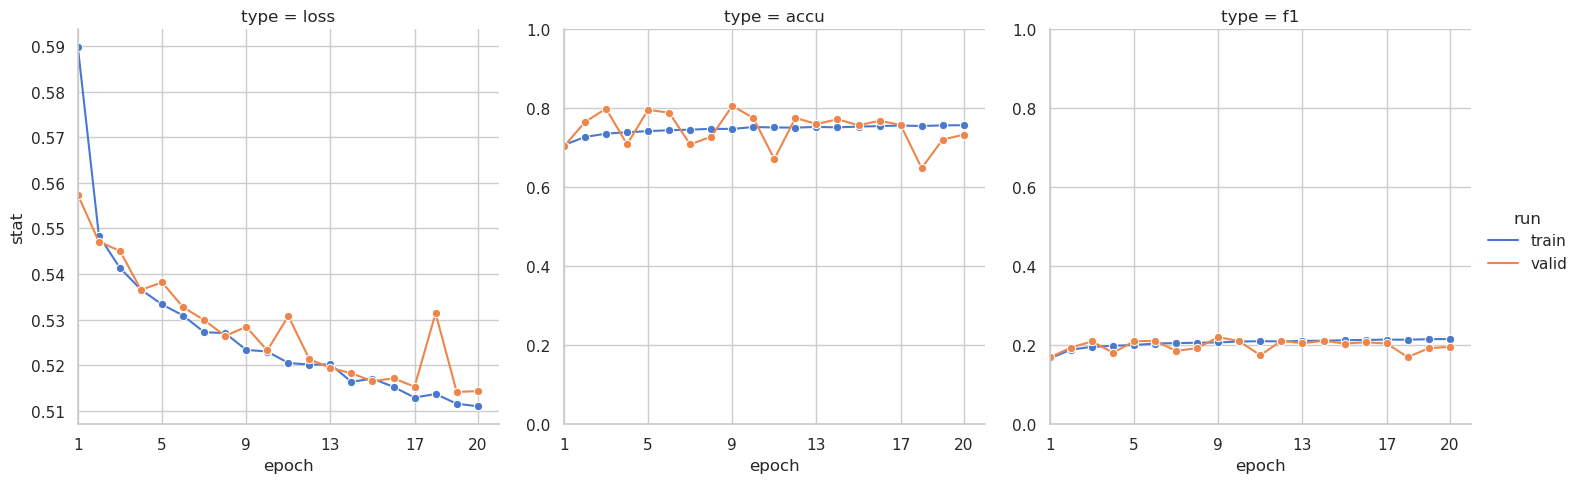

0.04324024894913487 0.28857245267033793


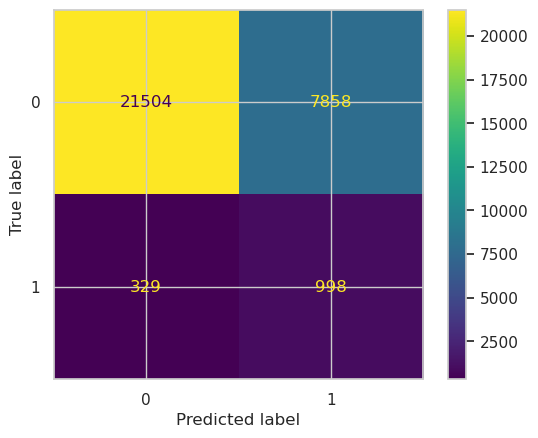

In [13]:
train_loader, valid_loader, test_loader = get_dataloaders()
model = main(criterion, train_loader, valid_loader)
draw_confusion_matrix(model, valid_loader)

### Model evaluation

Once satisfied with the model, you can evaluate the final model on the test set.
This is your *score* on this problem. Never be tempted to evaluate the model on
the test set beforehand: it's cheating.

In [14]:
validate(model, criterion, test_loader)

(0.5110252499580383, 0.7380048550807279, 0.20638602378719836)